Адаптивное преобразование

In [1]:
from PIL import Image
import math
from numpy import matrix
from numpy import linalg
import itertools
from matplotlib import pyplot as plt

import numpy as np
from scipy.stats import multivariate_normal


# Адаптивное преобразование
sunny_day = "sunny_day.jpg"
sudoku = "sudoku.jpg"

im = Image.open(sunny_day)


def flatten(listOfLists):
    "Flatten one level of nesting"
    return itertools.chain.from_iterable(listOfLists)


def brightness(r, g, b):
    return r * 0.222 + g * 0.707 + b * 0.071


def get_brightness_matrix(im):
    x, y = im.size
    result = []
    for i in range(x):
        row = []
        for j in range(y):
            row.append(brightness(* im.getpixel((i, j))))
        result.append(row)
    return result

# TODO вложенные списочные выражения


def calc_location(x, y, matrix, size=2):
    left_gor = max(y - size, 0)
    right_gor = min(y + size, len(matrix))
    left_ver = max(x - size, 0)
    right_ver = min(x + size, len(matrix))
    result = []
    for i in range(left_gor, right_gor + 1):
        for j in range(left_ver, right_ver + 1):
            result.append(matrix[j][i])
    return sum(result) / max(len(result), 1)


def get_gauss_window(x, y, matrix, GF, size=2):
    left_gor = max(y - size, 0)
    right_gor = min(y + size, len(matrix))
    left_ver = max(x - size, 0)
    right_ver = min(x + size, len(matrix))
    result = []
    for i in range(left_gor, right_gor + 1):
        for j in range(left_ver, right_ver + 1):
            result.append(matrix[j][i] * GF[i - left_gor][j - left_ver])
            
    return sum(result)


def get_gauss_matrix(im, size=2):
    matrix = get_brightness_matrix(im)
    res = im.copy()
    x, y = im.size
    z = cv2.getGaussianKernel(2 * size + 1, sigma=1).reshape(1, 2 * size + 1)
    GF = np.dot(z.T,z)
    for i in range(x - size):
        for j in range(y - size):
            threshold = get_gauss_window(i, j, matrix, GF)
            value = get_pixel(threshold, matrix[i][j])
#             print(threshold, matrix[i][j])
            res.putpixel((i, j), value)
    return res
    

def get_pixel(theshold, bright):
    return (255, 255, 255) if bright >= theshold else (0, 0, 0)


def get_white_black_im(im, size=1, theshold=127, adaptive=True):
    matrix = get_brightness_matrix(im)
    res = im.copy()
    x, y = im.size
    for i in range(x - size):
        for j in range(y - size):
            if adaptive:
                value = get_pixel(calc_location(i, j, matrix, size), matrix[i][j]) 
            else:
                value = get_pixel(theshold, matrix[i][j])
            res.putpixel((i, j), value)
    return res


def get_grey_scaled_im(im):
    res = im.copy()
    matr = get_brightness_matrix(im)
    x, y = im.size
    for i in range(x):
        for j in range(y):
            res.putpixel(tuple([i, j]), (int(matr[i][j]), int(matr[i][j]), int(matr[i][j])))

    return res

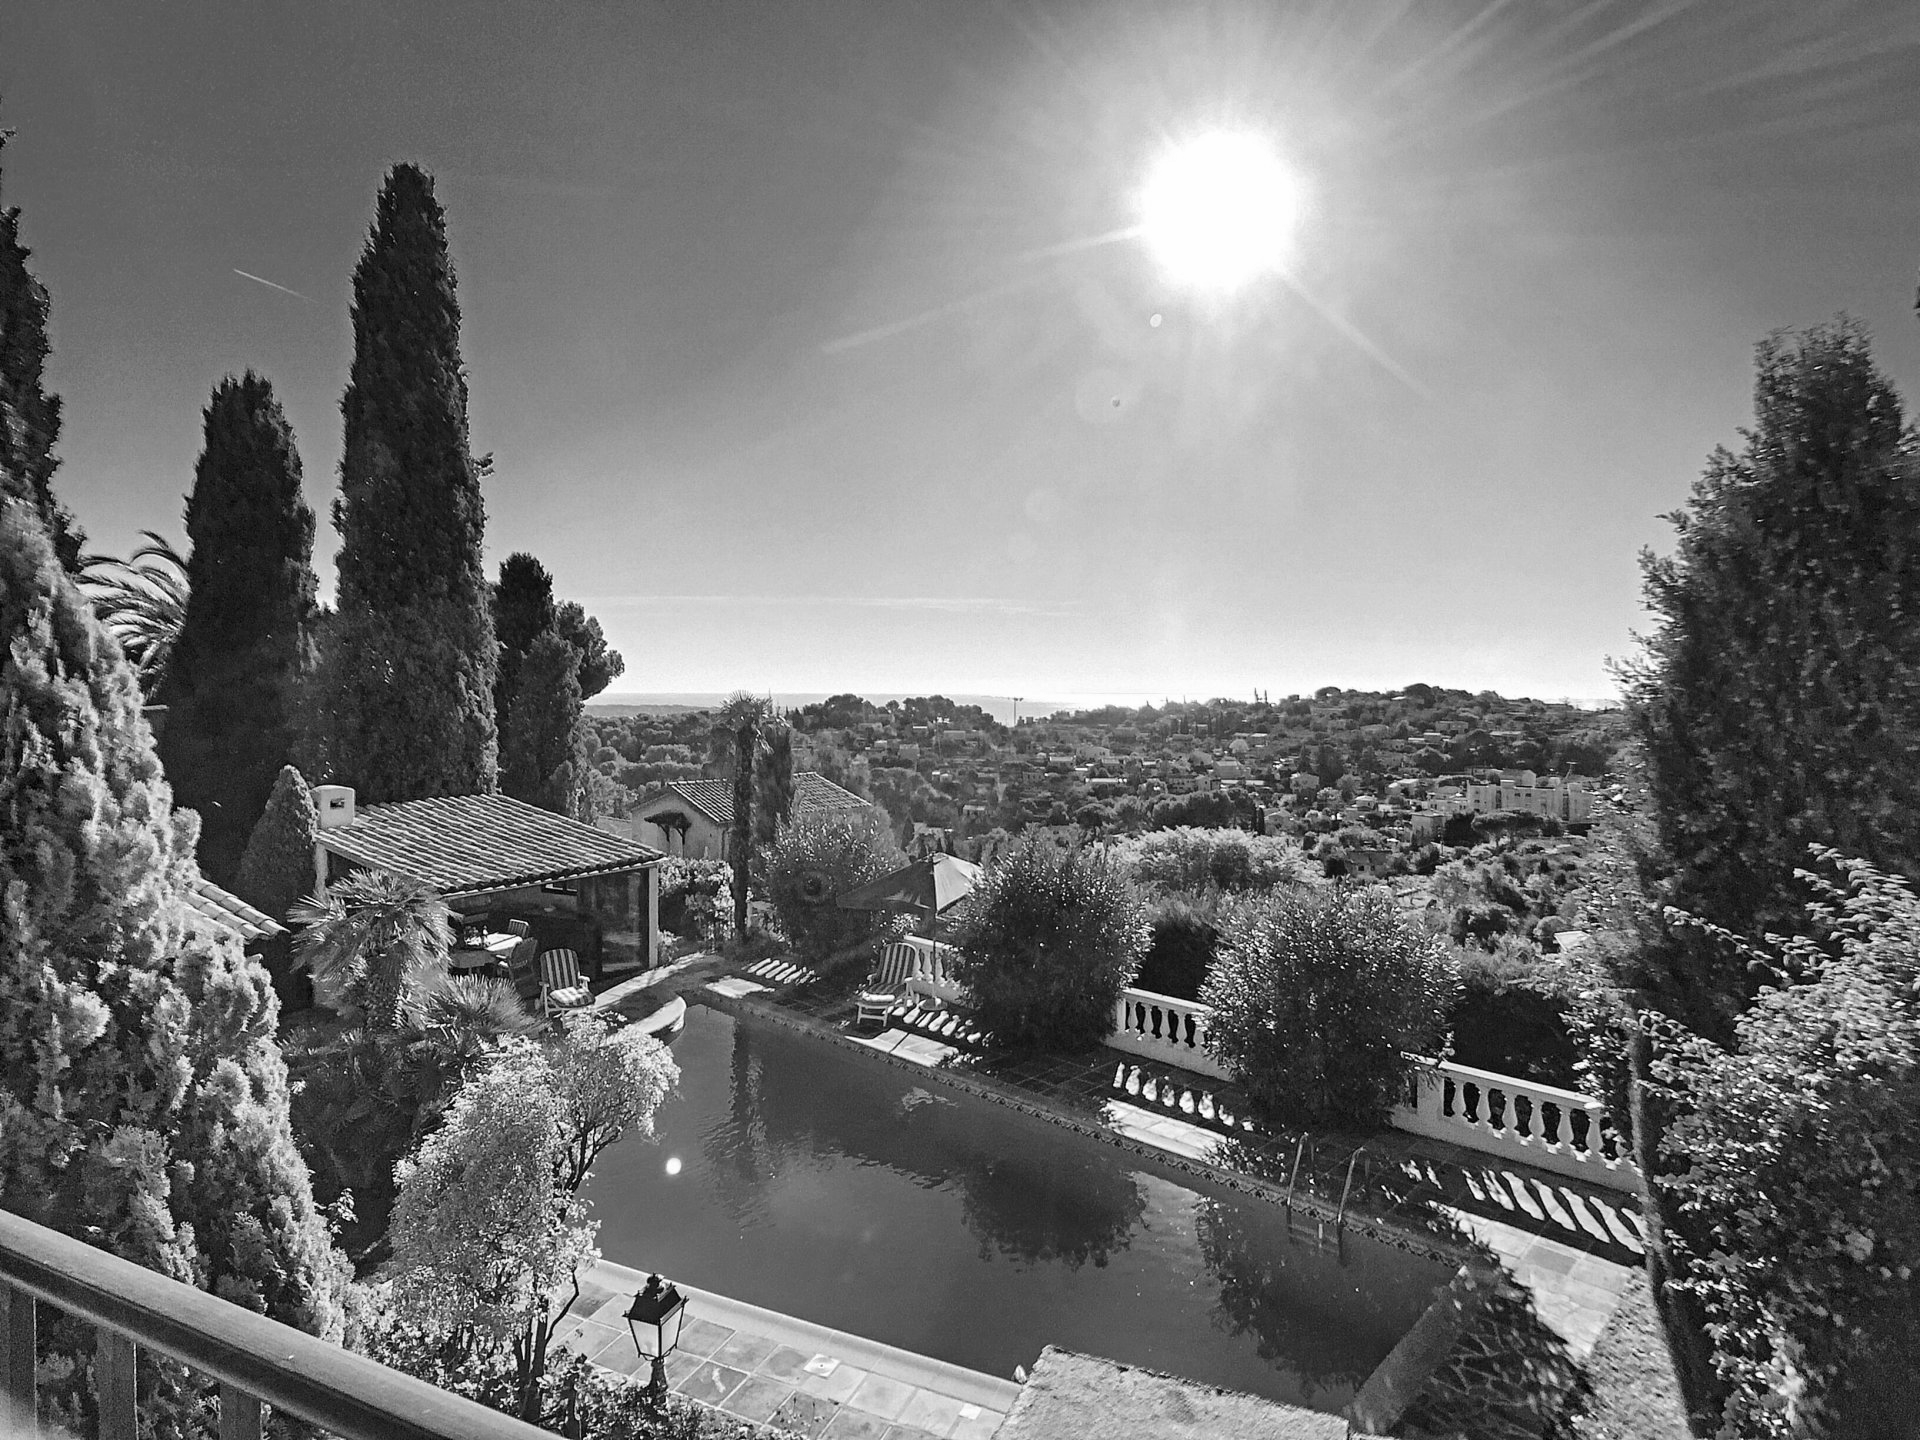

In [133]:
get_grey_scaled_im(im)

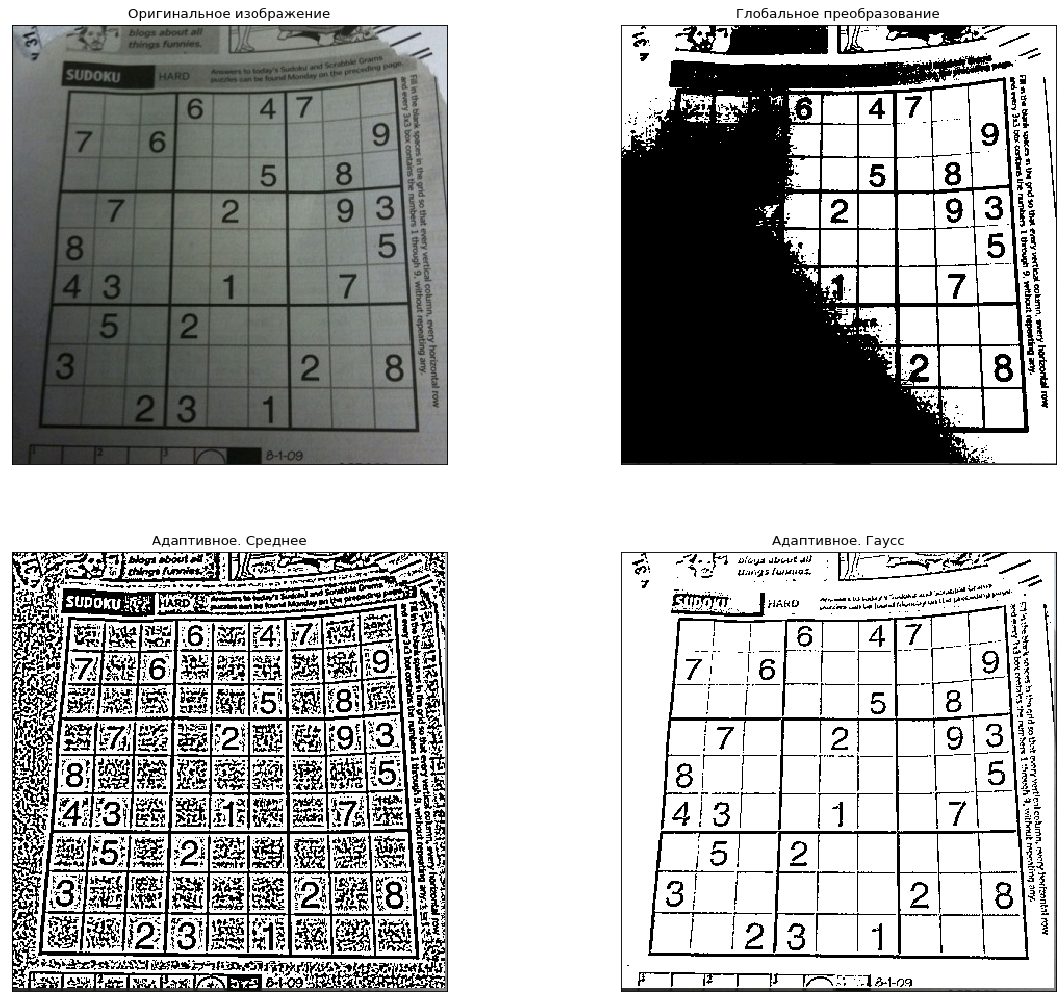

CPU times: user 6.93 s, sys: 56.9 ms, total: 6.99 s
Wall time: 7.06 s


In [2]:
%%time
import cv2

im = Image.open(sudoku)
img = cv2.imread(sudoku,0)
# ret,th4 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
th1 = get_white_black_im(im, 1, 110, False)
th2 = get_white_black_im(im, 3)
th4 = get_gauss_matrix(im, 3)

titles = ["Оригинальное изображение", "Глобальное преобразование",
            "Адаптивное. Среднее", "Адаптивное. Гаусс"]
images = [im, th1, th2, th4]
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

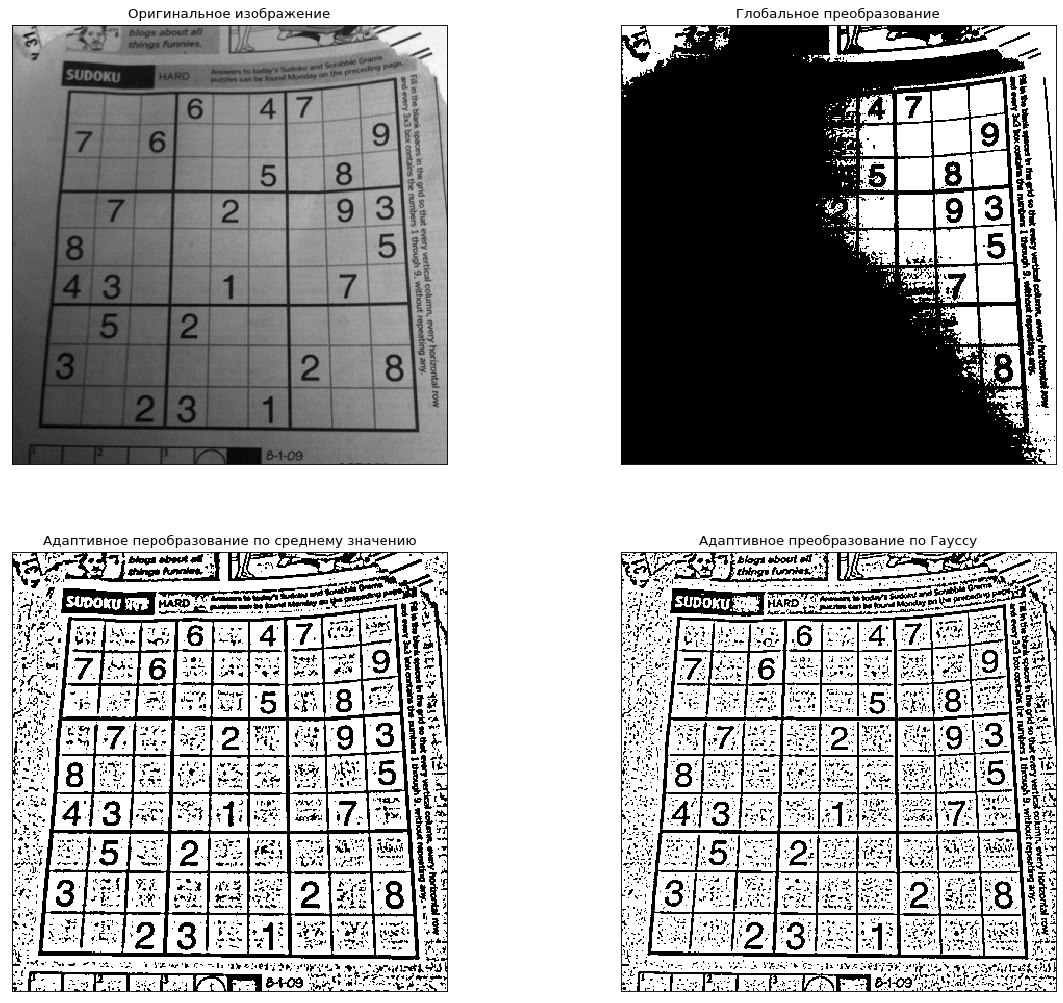

In [42]:

img = cv2.imread(source_path + file_name,0)
ret,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

titles = ['Оригинальное изображение', 'Глобальное преобразование',
            'Адаптивное перобразование по среднему значению', 'Адаптивное преобразование по Гауссу']
images = [img, th1, th2, th3]
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

Алгоритм поворота изображений


In [108]:
angle = math.radians(30)
matricies = {
    "1": [[1, 0], [-math.tan(angle/2), 1]], 
    "2": [[1, math.sin(angle)], [0, 1]],
    "3": [[1, 0], [-math.tan(angle/2), 1]]
}

def rot_x(ptx, pty, matrix):
    return matrix[0][0] * ptx + matrix[0][1] * pty


def rot_y(ptx, pty, matrix):
    return matrix[1][0] * ptx + matrix[1][1] * pty


def exp_mat(mat, mnx, mny):
    T = matrix([[*mat[0], -mnx], [*mat[1], -mny], [0, 0, 1]])
    return T


def rot_im(im, key):
    x, y = im.size
    mat = matricies[key]
    xextremes = [rot_x(0, 0, mat),rot_x(0, y-1, mat),rot_x(x-1, 0, mat),rot_x(x-1, y-1, mat)]
    yextremes = [rot_y(0, 0, mat),rot_y(0, y-1, mat),rot_y(x-1, 0, mat),rot_y(x-1, y-1, mat)]
    mnx = min(xextremes)
    mxx = max(xextremes)
    mny = min(yextremes)
    mxy = max(yextremes)
    T = exp_mat(mat, mnx, mny)
    Tinv = linalg.inv(T);
    Tinvtuple = (Tinv[0,0],Tinv[0,1], Tinv[0,2], Tinv[1,0],Tinv[1,1],Tinv[1,2])
    im1 = im.transform((int(round(mxx-mnx)),int(round((mxy-mny)))),Image.AFFINE,Tinvtuple,resample=Image.BILINEAR)
    return im1


In [109]:
%%time
source_path = "/home/ruslan/Изображения/"
file_name = "13435579505a11b7ee2cce96.11191120_1920.jpg"

im = Image.open(source_path + file_name)
f_im = rot_im(im, "1")
s_im = rot_im(f_im, "2")
t_im = rot_im(s_im, "3")

CPU times: user 683 ms, sys: 277 ms, total: 959 ms
Wall time: 468 ms


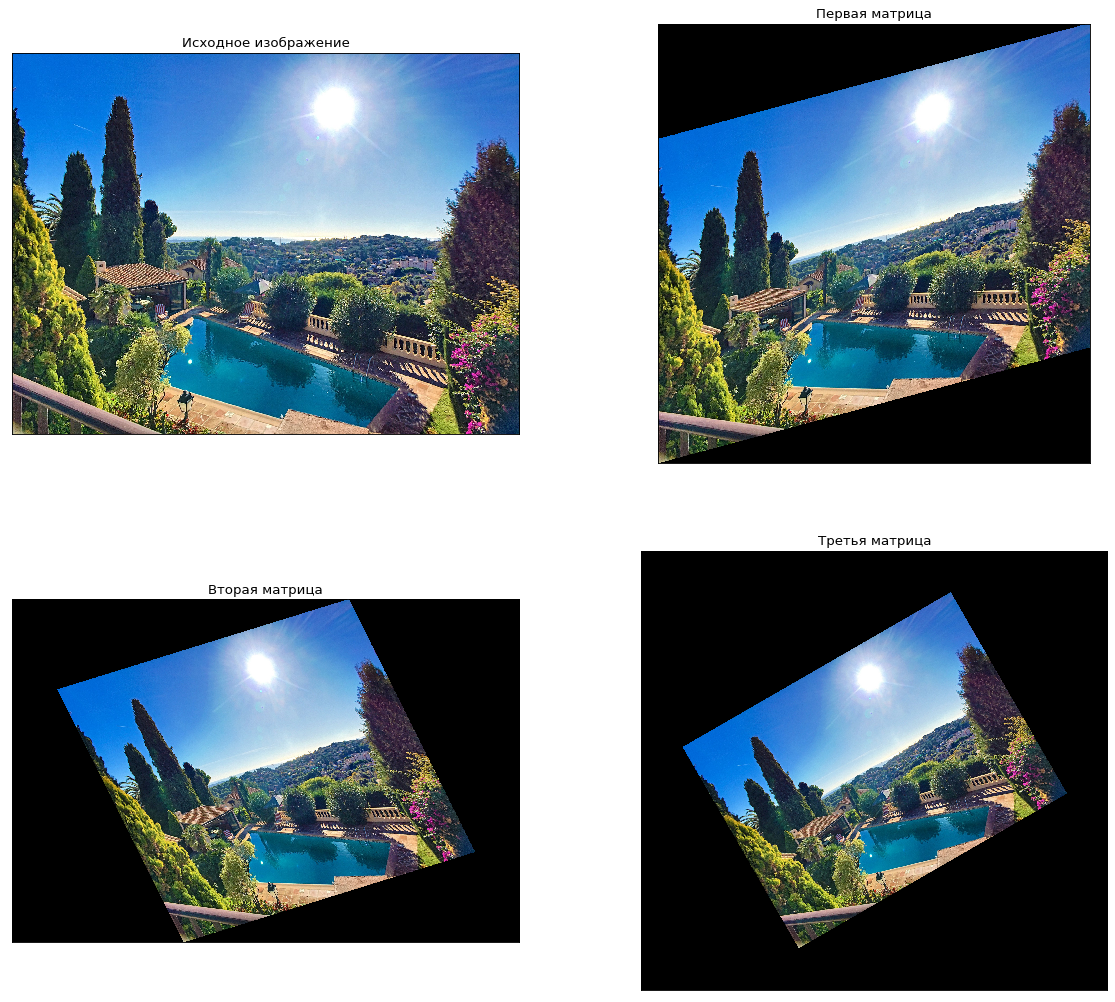

In [110]:
images = [im,f_im,s_im,t_im]
titles = ["Исходное изображение", "Первая матрица", "Вторая матрица", "Третья матрица"]
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i])
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()